## Project "Startups operations/close predictions"

### Project description
Соревнование представляет собой увлекательный и практически важный опыт, ориентированный на студентов курса Data Science. Участникам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются. Соревнование проводится на популярной платформе Kaggle, что позволяет участникам не только применять на практике свои знания в области анализа данных и машинного обучения, но и освоить работу с этой платформой.

### Data info

    Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

* kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
* kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
* kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.

    Описание полей данных

1) name - Название стартапа
2) category_list - Список категорий, к которым относится стартап
3) funding_total_usd - Общая сумма финансирования в USD
4) status - Статус стартапа (закрыт или действующий)
5) country_code - Код страны
6) state_code - Код штата
7) region - Регион
8) city - Город
9) funding_rounds - Количество раундов финансирования
10) founded_at - Дата основания
11) first_funding_at - Дата первого раунда финансирования
12) last_funding_at - Дата последнего раунда финансирования
13) closed_at - Дата закрытия стартапа (если применимо)
14) lifetime - Время существования стартапа в днях

## Imports
Импорт модулей и глобальные переменные

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import phik


from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder


RANDOM_STATE = 666

## Functions and Classes
Глобальные функции и классы

In [3]:
def feature_gen(X, reference_date='2018-01-01'):
    X = X.copy() # копируем исходные данные

    # универсальное условие которое создасть недостающие даннные о lifetime для тренировочных данных
    # и founded_at для тестовых
    if 'founded_at' in X.columns and 'closed_at' in X.columns:
        mask = X['closed_at'].notna()
        X.loc[mask, 'lifetime'] = (X.loc[mask, 'closed_at'] - X.loc[mask, 'founded_at']).dt.days
        X.loc[~mask, 'lifetime'] = (datetime.strptime(reference_date, '%Y-%m-%d') - X.loc[~mask, 'founded_at']).dt.days
    elif 'lifetime' in X.columns and 'founded_at' not in X.columns:
        X['founded_at'] = (datetime.strptime(reference_date, '%Y-%m-%d') - pd.to_timedelta(X['lifetime'], unit='d'))
    if 'closed_at' in X.columns:
        X = X.drop(columns=['closed_at'])

    # создание признаков на основе дат
    X['days_to_first_funding'] = (X.first_funding_at - X.founded_at).dt.days # дни с основания до первого финансирования
    X['days_to_last_funding'] = (X.last_funding_at - X.founded_at).dt.days # дни с основания до последнего финансирования
    X['days_between_first_last'] = (X.last_funding_at - X.first_funding_at).dt.days # дней между первым и последним
    
    # дней в среднем между раундами финансирования
    X['avg_days_between_funding'] = np.where(X['funding_rounds'] == 1, 0, X['days_between_first_last'] / (X['funding_rounds'] - 1))
    # объем инвестиций в среднем за раунд
    X['avg_funding_per_round'] = np.where(X['funding_rounds'] == 0, 0, X['funding_total_usd'] / X['funding_rounds'])

    # даты в unix формате
    X['first_funding_epoch'] = X['first_funding_at'].astype('int64') / 10**9
    X['last_funding_epoch'] = X['last_funding_at'].astype('int64') / 10**9
    X['founded_epoch'] = X['founded_at'].astype('int64') / 10**9

    # базовые данные о датах больше не нужны
    X= X.drop(columns=['first_funding_at', 'last_funding_at', 'founded_at'])

    # количество категорий в category_list (0 если na)
    mask = X['category_list'].notna()
    X.loc[mask, 'categories_count'] = X.loc[mask, 'category_list'].apply(lambda x: len(x.split('|')))
    X.loc[~mask, 'categories_count'] = 0

    # отношение времени до первого финансирования к общему времени жизни стартапа
    X['lf_ratio'] = X['days_to_first_funding'] / X['lifetime']

    # логарифм общей суммы инвестиций
    X['funding_total_usd_log'] = np.log1p(X['funding_total_usd'])

    # семантический анализ названия стартапа (полож/отриц)
    def get_sentiment(text):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity

    X['name_sentiment'] = X['name'].iloc[:, ].apply(get_sentiment)

    return X

def handle_high_car(X):
    X = X.copy()  # копируем исходные данные

    X['category_list'] = X['category_list'].apply(lambda x: x.split('|')) # разделяем фразы на списки
    sentences = X['category_list'].tolist()

    model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

    def get_category_vector(categories, model):
        vectors = [model.wv[cat] for cat in categories if cat in model.wv]
        if len(vectors) > 0:
            return np.mean(vectors, axis=0)  # усредняем вектора
        else:
            return np.zeros(model.vector_size)  # нулевой вектор, если категорий нет в модели

    # применяем функцию к каждому списку категорий
    X['category_vector'] = X['category_list'].apply(lambda x: get_category_vector(x, model))

    # преобразуем список векторов в отдельные столбцы
    category_vectors = pd.DataFrame(X['category_vector'].tolist(), index=X.index)
    category_vectors.columns = [f'category_vec_{i}' for i in range(category_vectors.shape[1])]

    # объединяем все признаки
    X = pd.concat([X.drop(columns=['category_vector']), category_vectors], axis=1)
    X = X.drop(columns=['category_list'])
    X.info()
    return X, category_vectors.columns


def na_funding_influence(data):
    print(f'Количество стартапов и их раундов финансирования с отсутствующей суммой:{data[data.funding_total_usd.isna()][["funding_rounds"]].value_counts()}')
    print(f'\nРаспределение целевой переменной для этой категории:{data[data.funding_total_usd.isna()][["status"]].value_counts()}\n')
    print(f'Процент отсутствующих данных по финансированию от всех: {data.funding_total_usd.isna().sum() * 100 / data.shape[0]:.2f}%')
    print(f'Процент закрывшихся стартапов для этой категории относительно общего числа закрытых: {data[data.funding_total_usd.isna() & data.status.isin(["closed"])].shape[0] * 100 / data.status.isin(["closed"]).sum():.2f}%')

def correct_dates(data):
    median_diff = (data.loc[data['founded_at'] <= data['first_funding_at'], 'first_funding_at'] - data.loc[data['founded_at'] <= data['first_funding_at'], 'founded_at']).median()
    # Корректировка данных с ошибкой в дате
    data.loc[data['founded_at'] > data['first_funding_at'], 'founded_at'] = data.loc[data['founded_at'] > data['first_funding_at'], 'first_funding_at'] - median_diff
    # Проверка корректировки
    print('Стартапы с ошибками в датах относительно founded_at после корректировки:')
    print(data[(data['founded_at'] > data['first_funding_at']) | (data['founded_at'] > data['last_funding_at'])].shape[0])
    return data


## Data read
Изучим предоставленные данные

In [4]:
data = pd.read_csv('datasets/kaggle_startups_train_28062024.csv', parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])
test = pd.read_csv('datasets/kaggle_startups_test_28062024.csv', parse_dates=['first_funding_at', 'last_funding_at'])

In [133]:
data.info()
display(data.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Columns: 126 entries, funding_total_usd to low_lt
dtypes: float32(100), float64(16), int32(5), int64(5)
memory usage: 29.4 MB


funding_total_usd  status  funding_rounds  high_na  lifetime  \
43179           500000.0       1               1        0    1002.0   
8097          86835593.0       0               6        0    3232.0   
14600         69426794.0       0               5        0    6172.0   

       days_to_first_funding  days_to_last_funding  days_between_first_last  \
43179                    445                   445                        0   
8097                     397                  1328                      931   
14600                   2366                  4468                     2102   

       avg_days_between_funding  avg_funding_per_round  ...  category_vec_94  \
43179                       0.0           5.000000e+05  ...         0.336358   
8097                      186.2           1.447260e+07  ...         0.428238   
14600                     525.5           1.388536e+07  ...         0.205303   

       category_vec_95  category_vec_96  category_vec_97  category_vec_98  \
43179         0.353811        -0.187999        -0.053882         0.174172   
8097          0.352559        -0.021159        -0.154058         0.375362   
14600         0.277679         0.288225        -0.200417        -0.126244   

       category_vec_99  high_lf_ratio  had_low_rounds  low_funding  low_lt  
43179        -0.375361              1               1            0       1  
8097          0.372583              0               0            0       0  
14600        -0.076996              0               0            0       0  

[3 rows x 126 columns]

In [6]:
test.info()
display(test.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


name                      category_list  \
4362         Bright Power     Energy|Energy Management|Solar   
2086  BioFire Diagnostics   Biotechnology|Health Diagnostics   
1385               DoneBy  Content|Content Creators|Internet   

      funding_total_usd country_code state_code          region  \
4362          6500000.0          USA         NY   New York City   
2086         70000000.0          USA         UT  Salt Lake City   
1385          1830000.0          NaN        NaN             NaN   

                city  funding_rounds first_funding_at last_funding_at  \
4362        New York               2       2013-05-31      2014-12-17   
2086  Salt Lake City               2       2012-09-19      2013-05-02   
1385             NaN               3       2013-05-01      2014-06-01   

      lifetime  
4362      4752  
2086     10227  
1385      1826

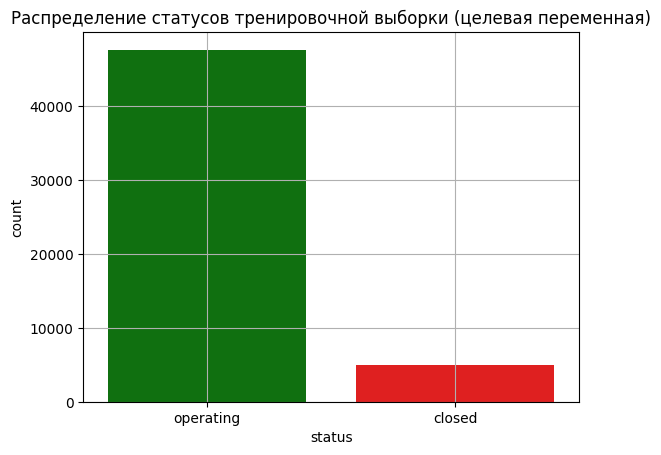

In [7]:
ax = sns.countplot(data=data, x='status', hue='status', palette={'operating': 'green', 'closed': 'red'})
ax.set_title('Распределение статусов тренировочной выборки (целевая переменная)')
ax.grid(True)
plt.show()

Представленные данные имеют выраженный дисбаланс классов, также в тестовой выборке отсутствует поле даты основания стартапа, а в тестовой срок его жизни. Так как предоставлена дата выгрузки данных "2018-01-01", восстановим поля для обоих датасетов отталкиваясь от нее.

## Initial data assessment
Прведем первичную оценку предоставленных тренировочных данных

In [8]:
print(f'Пропуски в представленных данных:\n{data.isna().sum()}')

Пропуски в представленных данных:
name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64


Данные имеют большое количество пропусков, однако данные о финансировинии представлены в полном объеме. Большое количество пропусков closed_at объясняется дисбалансом классов.

In [9]:
print('Строка с отсутствующим именем стартапа:')
display(data[data["name"].isna()])

Строка с отсутствующим именем стартапа:


name category_list  funding_total_usd  status country_code state_code  \
3291  NaN      Startups            25000.0  closed          USA         OR   

                region      city  funding_rounds founded_at first_funding_at  \
3291  Portland, Oregon  Portland               1 2011-10-01       2012-03-01   

     last_funding_at  closed_at  
3291      2012-03-01 2013-06-03

Имя стартапа пропущено всего для одной строки.

In [10]:
print('Уникальных значений признаков в тренировочных данных:')
data.nunique()

Уникальных значений признаков в тренировочных данных:


name                 52515
category_list        22105
funding_total_usd    15551
status                   2
country_code           134
state_code             300
region                1036
city                  4477
funding_rounds          19
founded_at            5402
first_funding_at      4603
last_funding_at       4305
closed_at             3008
dtype: int64

Данные преимущественно состоят из категорилальных признаков с высокой кардинальностью, для списка категорий применим векторизацию, название стартапа оценим семантически, а к данным о местоположении стартапа применим TargetEncoding

In [11]:
print('Пример категорий стартапов:')
display(data.category_list.sample(10))

Пример категорий стартапов:


30437    Event Management|Marketplaces|Real Estate|Serv...
45805            E-Commerce|Fashion|Health Care|Technology
33411                                          Curated Web
18255                                               Mobile
18709    Cloud Computing|Computer Vision|Digital Media|...
28480                                  Enterprise Software
23856    Crowdfunding|Finance Technology|Financial Serv...
41096                                          Curated Web
9117                                              Software
44302                                  Enterprise Software
Name: category_list, dtype: object

Категории перечислены через пайп, и отсортированы в строке по первой букве слова, при разбиении слов на списки это необходимо учесть.

In [12]:
print('Меры центральной тенденции признака funding_total_usd:')
data.funding_total_usd.describe()

Меры центральной тенденции признака funding_total_usd:


count    4.244700e+04
mean     1.824748e+07
std      1.871173e+08
min      1.000000e+00
25%      3.360275e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

Распределение общей суммы инвестиций имеет очень большой размах, для нормализации целесообразно применить логарифмирование. Так как минимальное значение составляет всего один доллар, предположим, что пропусками обозначен провал в привлечении инвестиций или ноль.

In [13]:
na_funding_influence(data)

Количество стартапов и их раундов финансирования с отсутствующей суммой:funding_rounds
1                 9189
2                  706
3                  121
4                   36
5                    8
6                    3
7                    2
10                   2
8                    1
9                    1
Name: count, dtype: int64

Распределение целевой переменной для этой категории:status   
operating    9044
closed       1025
Name: count, dtype: int64

Процент отсутствующих данных по финансированию от всех: 19.17%
Процент закрывшихся стартапов для этой категории относительно общего числа закрытых: 20.85%


Пропуски в данных об инвестировании составляют ~20% от общего числа данных, и положительное значение целевого признака (closed) составляет ~20% от общего числа положительных значений.

In [14]:
for col in data.select_dtypes(include='datetime64[ns]').columns:
    print(f'{col}: минимальное значение даты {data[col].min()} - максимальное значение даты {data[col].max()}')

founded_at: минимальное значение даты 1970-02-05 00:00:00 - максимальное значение даты 2016-04-02 00:00:00
first_funding_at: минимальное значение даты 1977-05-15 00:00:00 - максимальное значение даты 2015-12-05 00:00:00
last_funding_at: минимальное значение даты 1977-05-15 00:00:00 - максимальное значение даты 2015-12-07 00:00:00
closed_at: минимальное значение даты 1983-10-06 00:00:00 - максимальное значение даты 2017-10-21 00:00:00


В данных, если это не ошибка представлены стартапы с 1970 года.

## Errors and NA
Оценим данные на ошибки в датах и большое количество пропусков в строках

In [15]:
print('Стартапы с ошибками в датах относительно founded_at (Дата основания больше даты первого или последнего финансирования):')
print('Строк, учитывая last_funding_at:',data[(data['founded_at'] > data['first_funding_at']) | (data['founded_at'] > data['last_funding_at'])].shape[0], '\n')
data[(data['founded_at'] > data['first_funding_at'])].info()
print('\nСтартапы с ошибками в датах относительно first_funding_at:')
print('Всего строк:',data[(data['first_funding_at'] > data['last_funding_at'])].shape[0])

Стартапы с ошибками в датах относительно founded_at (Дата основания больше даты первого или последнего финансирования):
Строк, учитывая last_funding_at: 2935 

<class 'pandas.core.frame.DataFrame'>
Index: 2935 entries, 34 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               2935 non-null   object        
 1   category_list      2847 non-null   object        
 2   funding_total_usd  2294 non-null   float64       
 3   status             2935 non-null   object        
 4   country_code       2642 non-null   object        
 5   state_code         2575 non-null   object        
 6   region             2618 non-null   object        
 7   city               2618 non-null   object        
 8   funding_rounds     2935 non-null   int64         
 9   founded_at         2935 non-null   datetime64[ns]
 10  first_funding_at   2935 non-null   datetime64[ns]
 11  last_funding_at 

Имеем 2935 записей для которых дата первого раунда инвестирования произошла раньше основания стартапа. Такие данные требуют коррекции, в качестве сдвига даты основания относительно даты первого инвестирования используем среднее значение этой разницы в днях по всем данным.

In [16]:
data = correct_dates(data)

Стартапы с ошибками в датах относительно founded_at после корректировки:
0


In [17]:
print(f'Стартапы, у которых более 3 пропущенных значений: {len(data[data.isna().sum(axis=1) > 3])}')
print(data[data.isna().sum(axis=1) > 3][['status']].value_counts())

Стартапы, у которых более 3 пропущенных значений: 6130
status   
operating    4828
closed       1302
Name: count, dtype: int64


Представленные тренировочные данные имеют достаточно большое количество строк в которых более 3 пропусков. Оценим как это выражается на целевой переменной.

In [18]:
print('Процент закрытых от общего числа закрытых стартапов с большим количеством пропусков:')
print(f'{(data[data.isna().sum(axis=1) > 3][["status"]].value_counts()/data[["status"]].value_counts()).iloc[1]*100:.2f}%')

Процент закрытых от общего числа закрытых стартапов с большим количеством пропусков:
26.48%


In [19]:
data['high_na'] = (data.isna().sum(axis=1) > 3).astype(int)

Так как данные с пропусками имеют иное распределение целевой переменной, создадим признак high_na который указывает на эти строки

### Statistical Data Analysis
Перед созданием дополнительных признаков, оценим базовые, предварительно заполнив числовые пропуски нулем, а пропуски в категориальных данных словом 'None'

In [20]:
txt_columns = data.select_dtypes(include='object').columns
num_columns = data.select_dtypes(include='number').columns

data[num_columns] = data.loc[:, num_columns].fillna(0)
data[txt_columns] = data.loc[:, txt_columns].fillna('None', axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
 13  high_na            52516 non-null  int32         
dtypes: dat

In [21]:
cat_columns = ['funding_rounds', 'high_na']
num_columns = ['funding_rounds', 'funding_total_usd']
high_car_columns = ['category_list', 'country_code', 'state_code', 'region', 'city']

Количество раундов финансирования оценим и как числовой и как категориальных признак, признаки с высокой кардинальностью выносим в отдельную категорию. Сами признаки будем анализировать отдельно для полных данных и данных имеющих большое количество пропусков в строках.

### Categorial

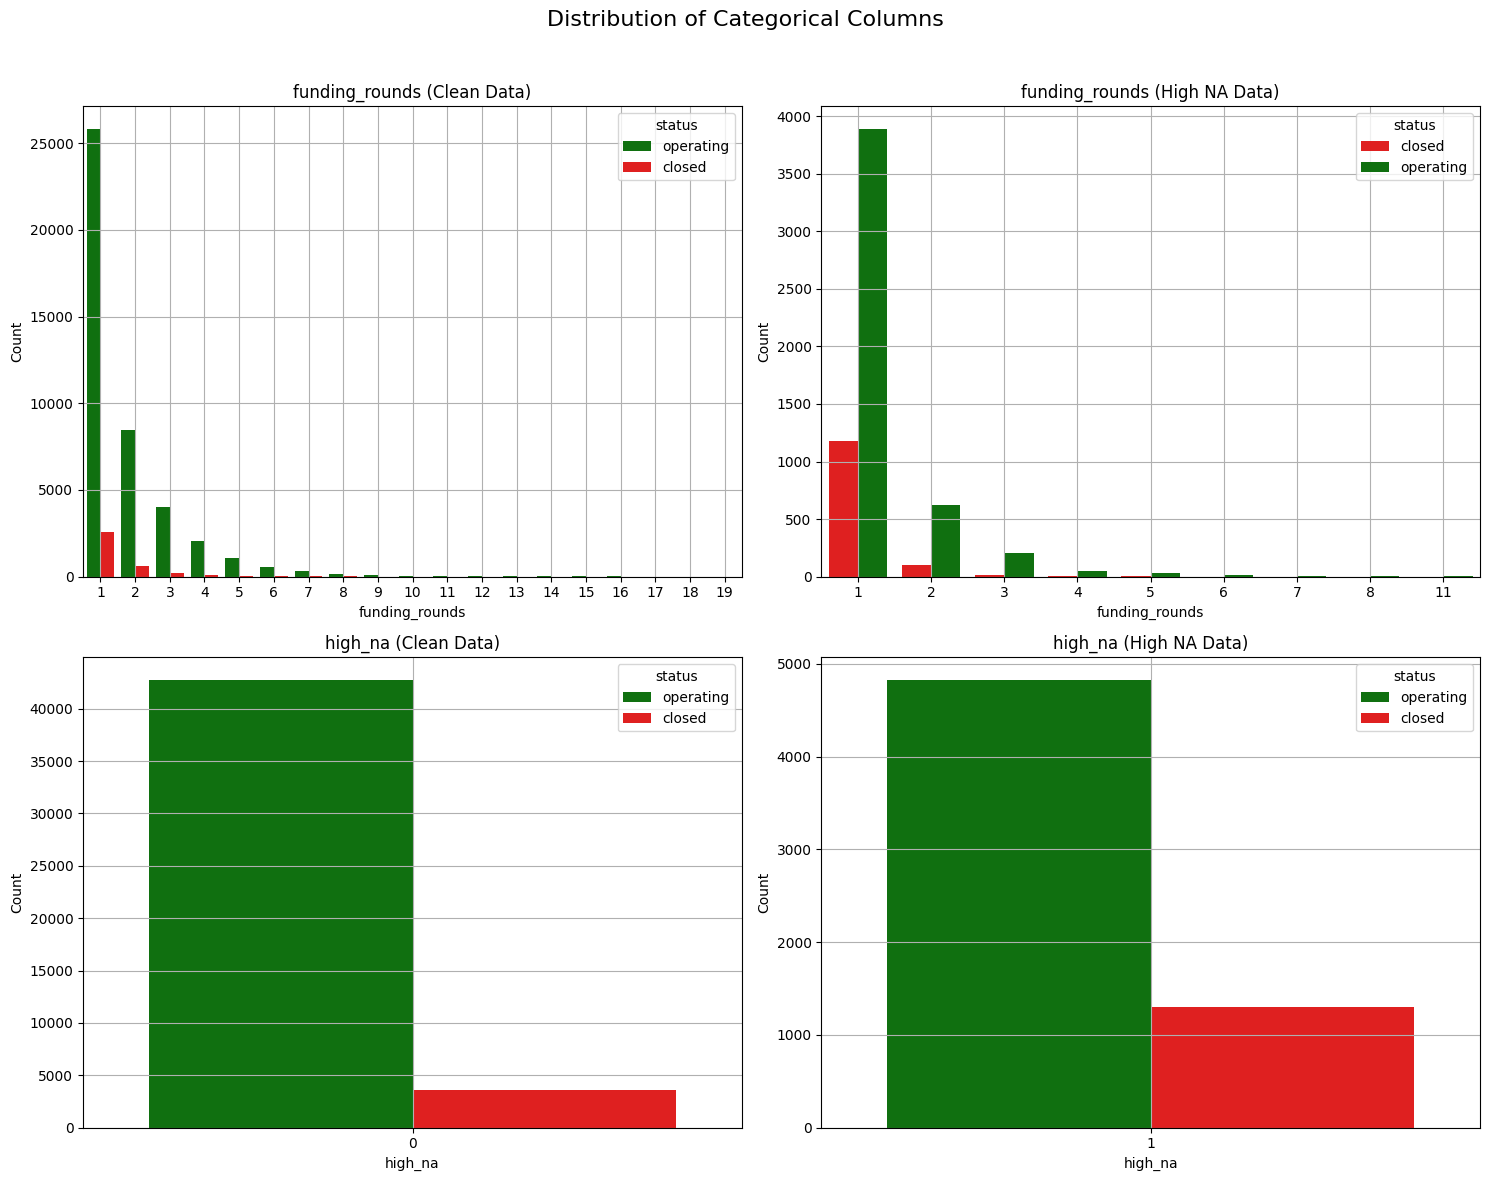

In [22]:
fig, axes = plt.subplots(nrows=len(cat_columns), ncols=2, figsize=(15, 6*len(cat_columns)))
fig.suptitle('Distribution of Categorical Columns', fontsize=16)

for i, col in enumerate(cat_columns):
    sns.countplot(data=data[data['high_na'] == 0], x=col, hue='status', palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} (Clean Data)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].grid(True)

    sns.countplot(data=data[data['high_na'] == 1], x=col, hue='status', palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} (High NA Data)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Большая часть закрывшихся стартапов в данных пережила всего 1 раунд финансирования

### Numerical

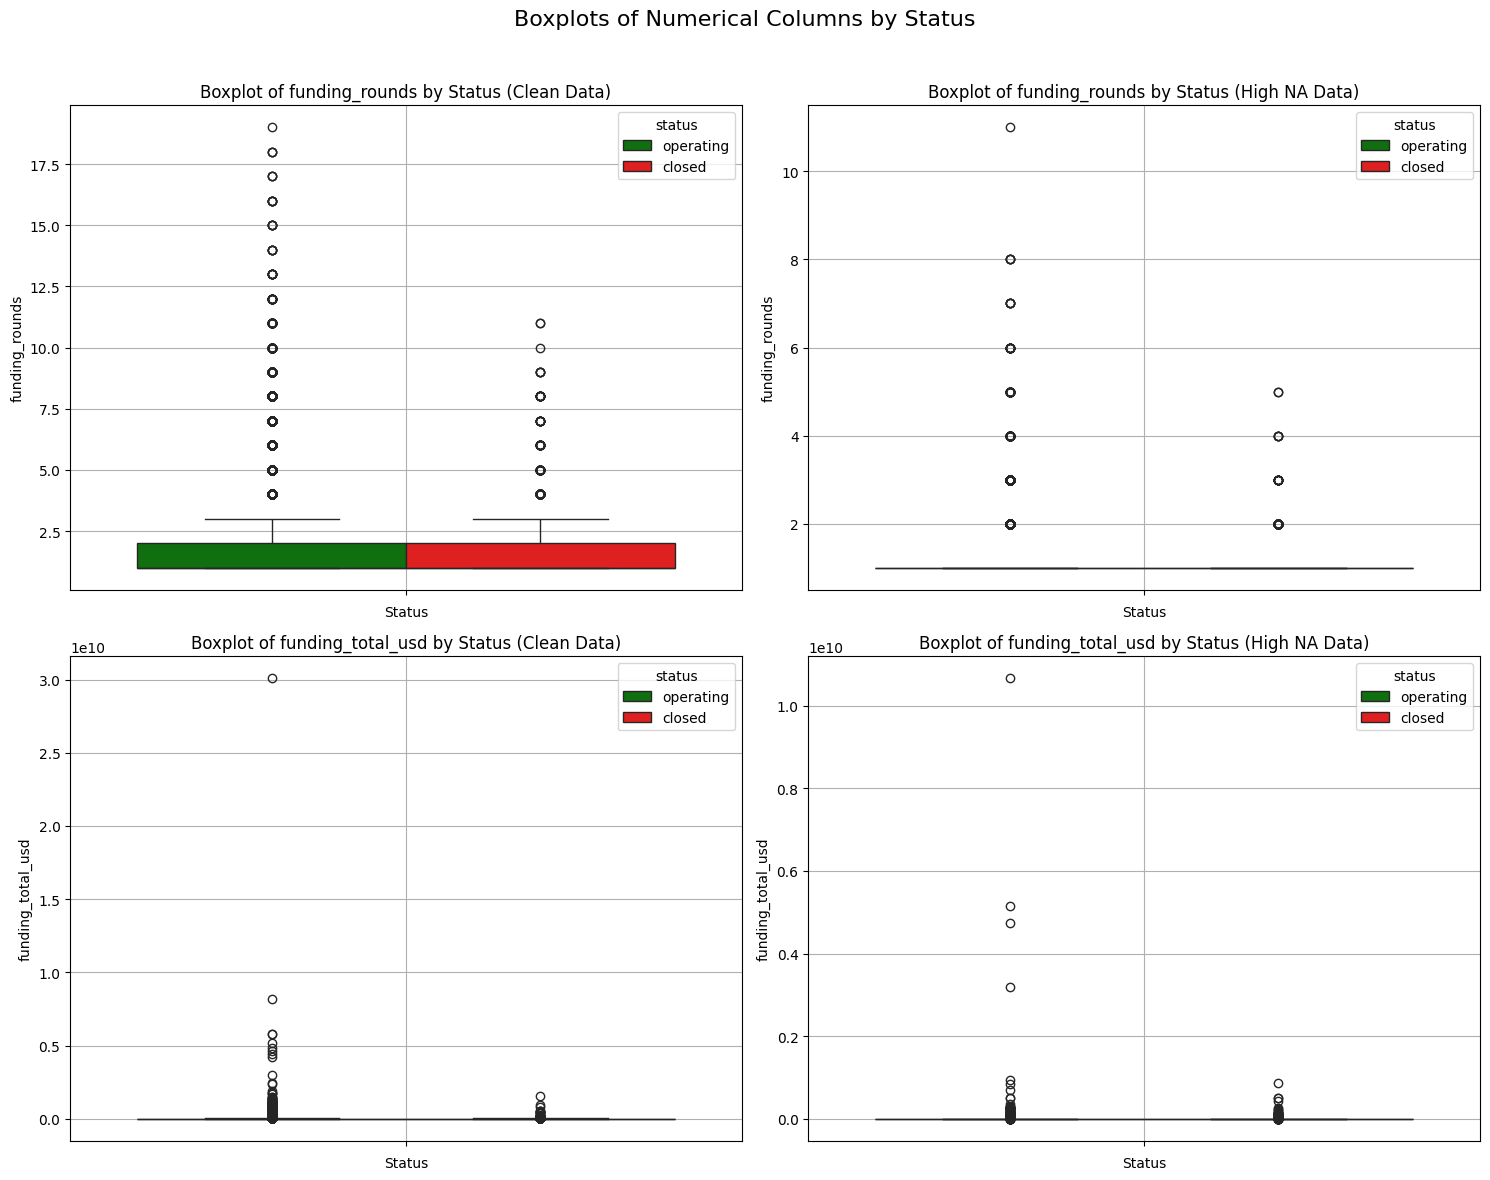

In [23]:
fig, axes = plt.subplots(nrows=len(num_columns), ncols=2, figsize=(15, 6* len(num_columns)))
fig.suptitle('Boxplots of Numerical Columns by Status', fontsize=16)

for i, col in enumerate(num_columns):
    sns.boxplot(data=data[data['high_na'] == 0], hue='status', y=col, palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 0])
    axes[i, 0].set_title(f'Boxplot of {col} by Status (Clean Data)')
    axes[i, 0].set_xlabel('Status')
    axes[i, 0].set_ylabel(col)
    axes[i, 0].grid(True)


    sns.boxplot(data=data[data['high_na'] == 1], hue='status', y=col, palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col} by Status (High NA Data)')
    axes[i, 1].set_xlabel('Status')
    axes[i, 1].set_ylabel(col)
    axes[i, 1].grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

За исключением отдельных выбросов большая часть стартапов пережила от 1 до 3 раудов финансирования. Объем привлеченных инвестиций имеет выбросы.

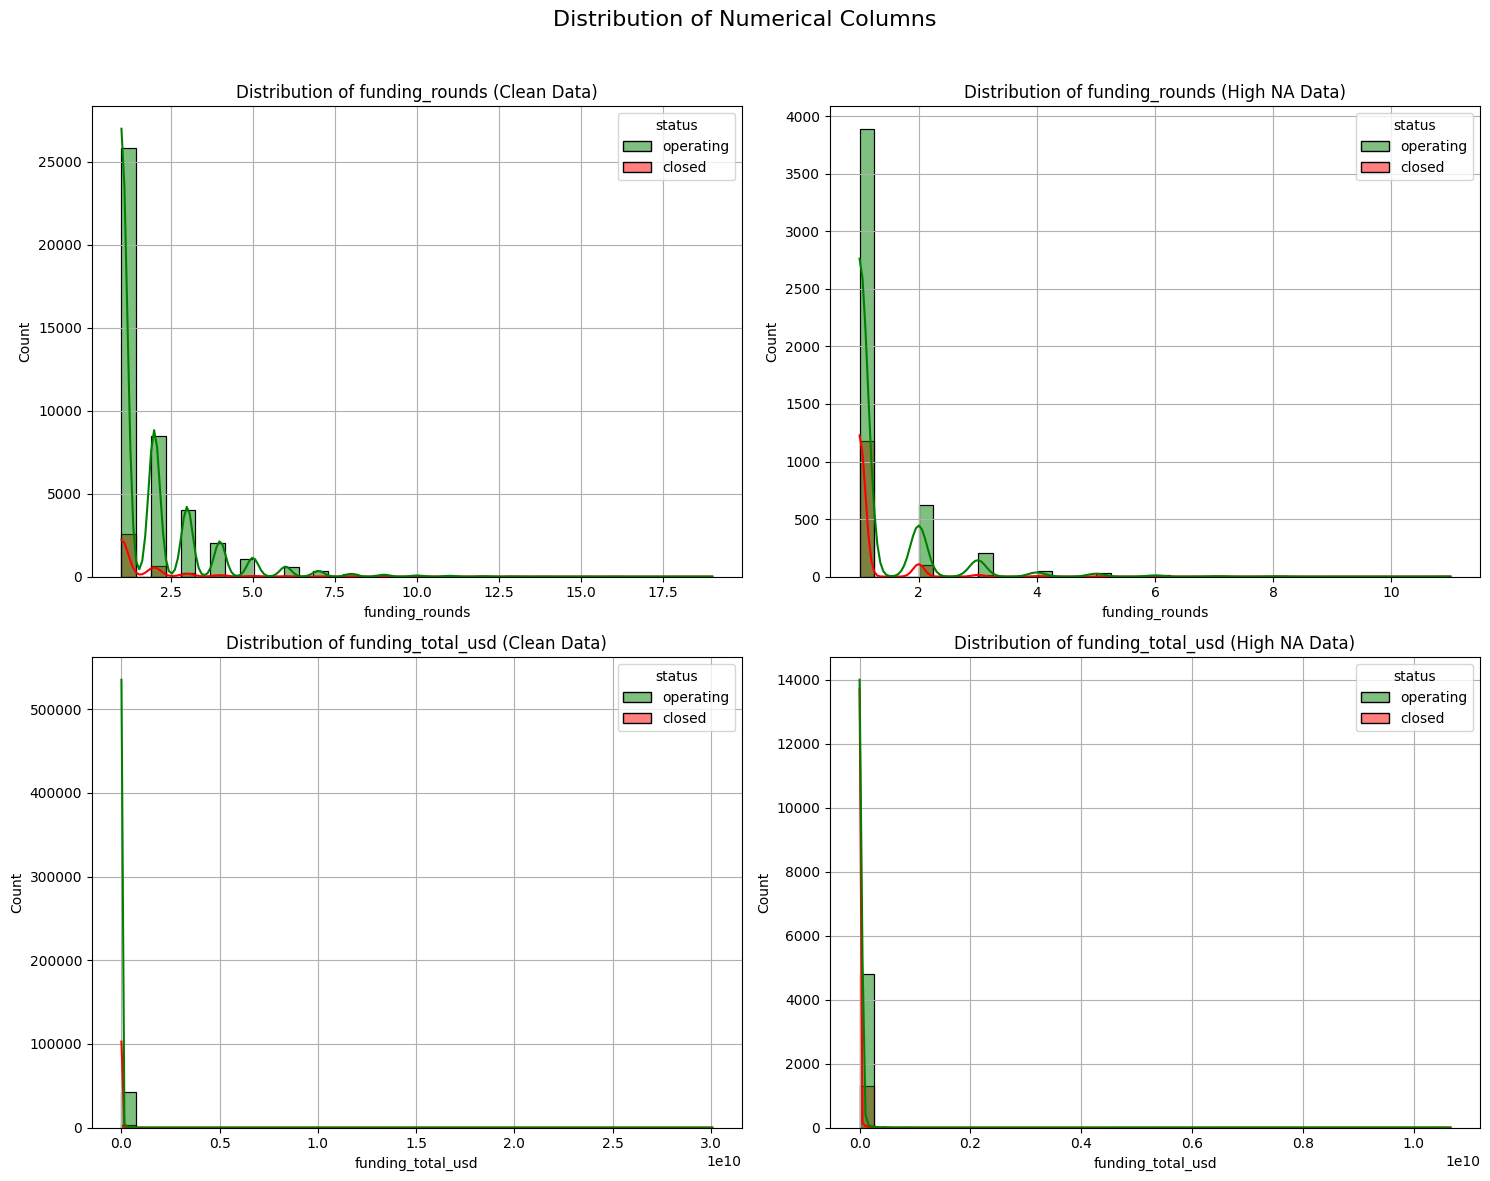

In [24]:
fig, axes = plt.subplots(nrows=len(num_columns), ncols=2, figsize=(15, 6*len(num_columns)))
fig.suptitle('Distribution of Numerical Columns', fontsize=16)

for i, col in enumerate(num_columns):
    sns.histplot(data=data[data['high_na'] == 0], x=col, hue='status', bins=40, ax=axes[i, 0], palette={'operating': 'green', 'closed': 'red'}, kde=True)
    axes[i, 0].set_title(f'Distribution of {col} (Clean Data)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].grid(True)

    sns.histplot(data=data[data['high_na'] == 1], x=col, hue='status', bins=40, ax=axes[i, 1], palette={'operating': 'green', 'closed': 'red'}, kde=True)
    axes[i, 1].set_title(f'Distribution of {col} (High NA Data)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Дополнительно оценим распределения признаков для различных значений целевого

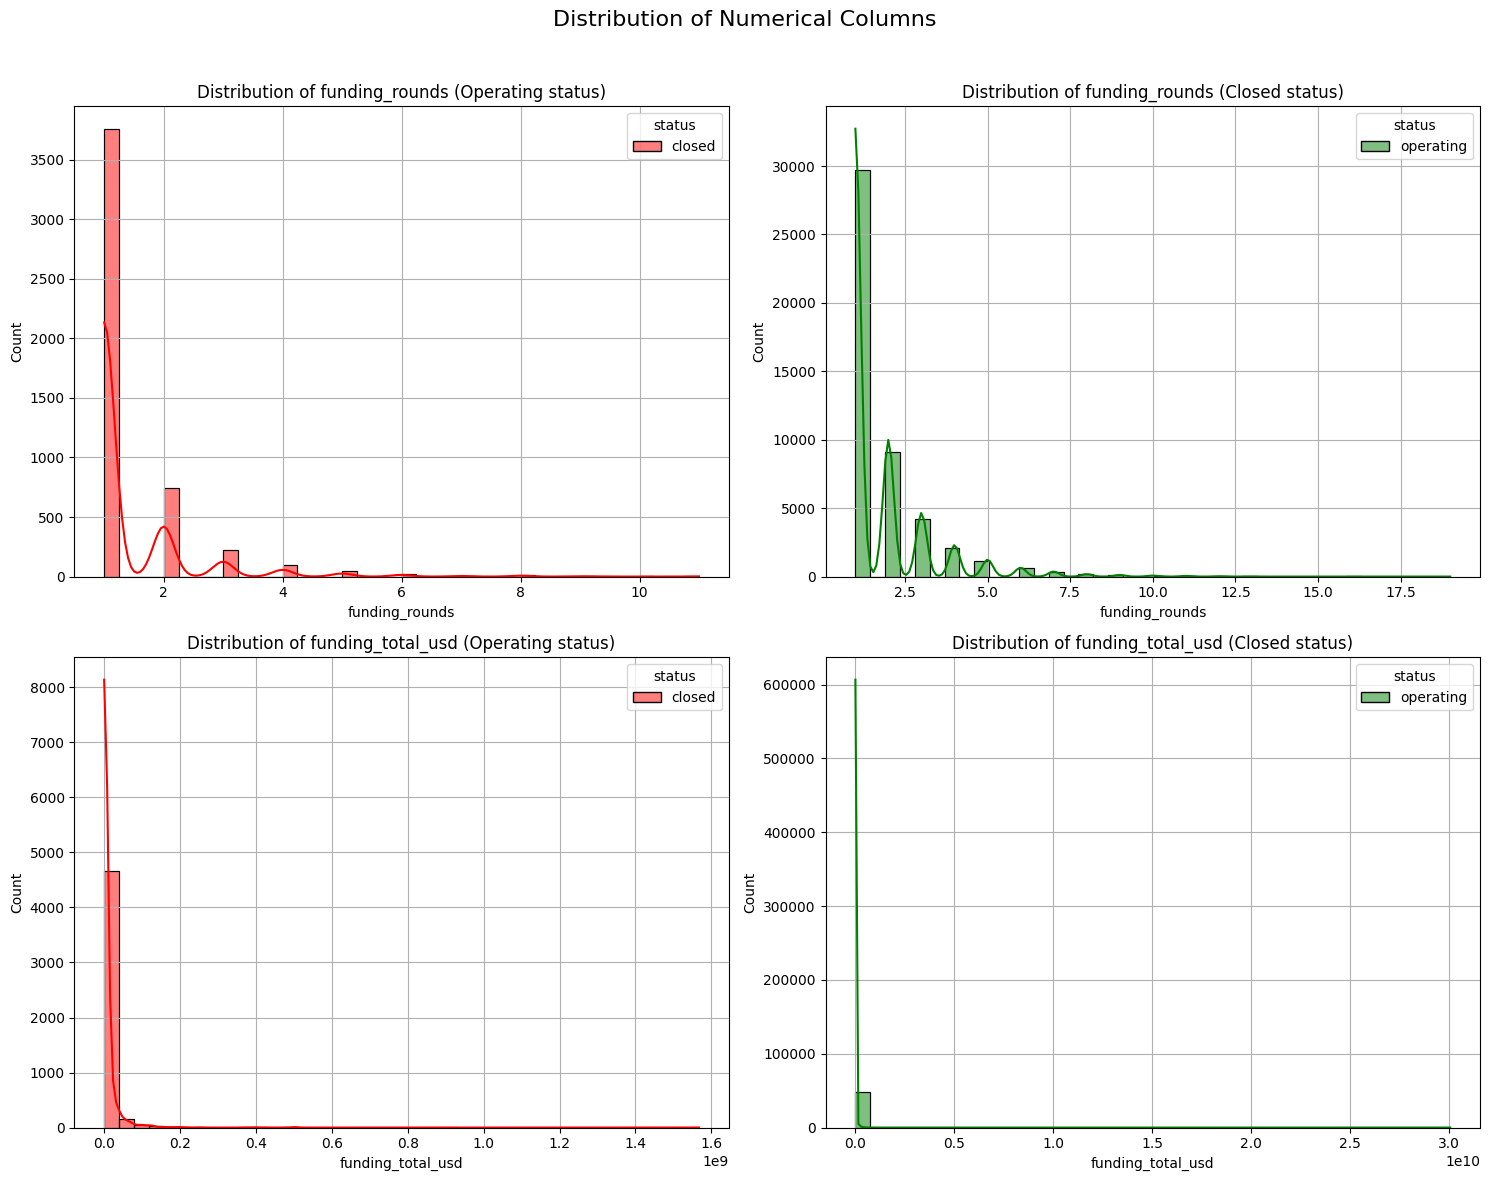

In [25]:
fig, axes = plt.subplots(nrows=len(num_columns), ncols=2, figsize=(15, 6*len(num_columns)))
fig.suptitle('Distribution of Numerical Columns', fontsize=16)

for i, col in enumerate(num_columns):
    sns.histplot(data=data[data['status'] == 'closed'], x=col, hue='status', bins=40, ax=axes[i, 0], palette={'operating': 'green', 'closed': 'red'}, kde=True)
    axes[i, 0].set_title(f'Distribution of {col} (Operating status)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].grid(True)

    sns.histplot(data=data[data['status'] == 'operating'], x=col, hue='status', bins=40, ax=axes[i, 1], palette={'operating': 'green', 'closed': 'red'}, kde=True)
    axes[i, 1].set_title(f'Distribution of {col} (Closed status)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### High Cardinality
Оценим 40 самых распространенных значений для этой категории признаков

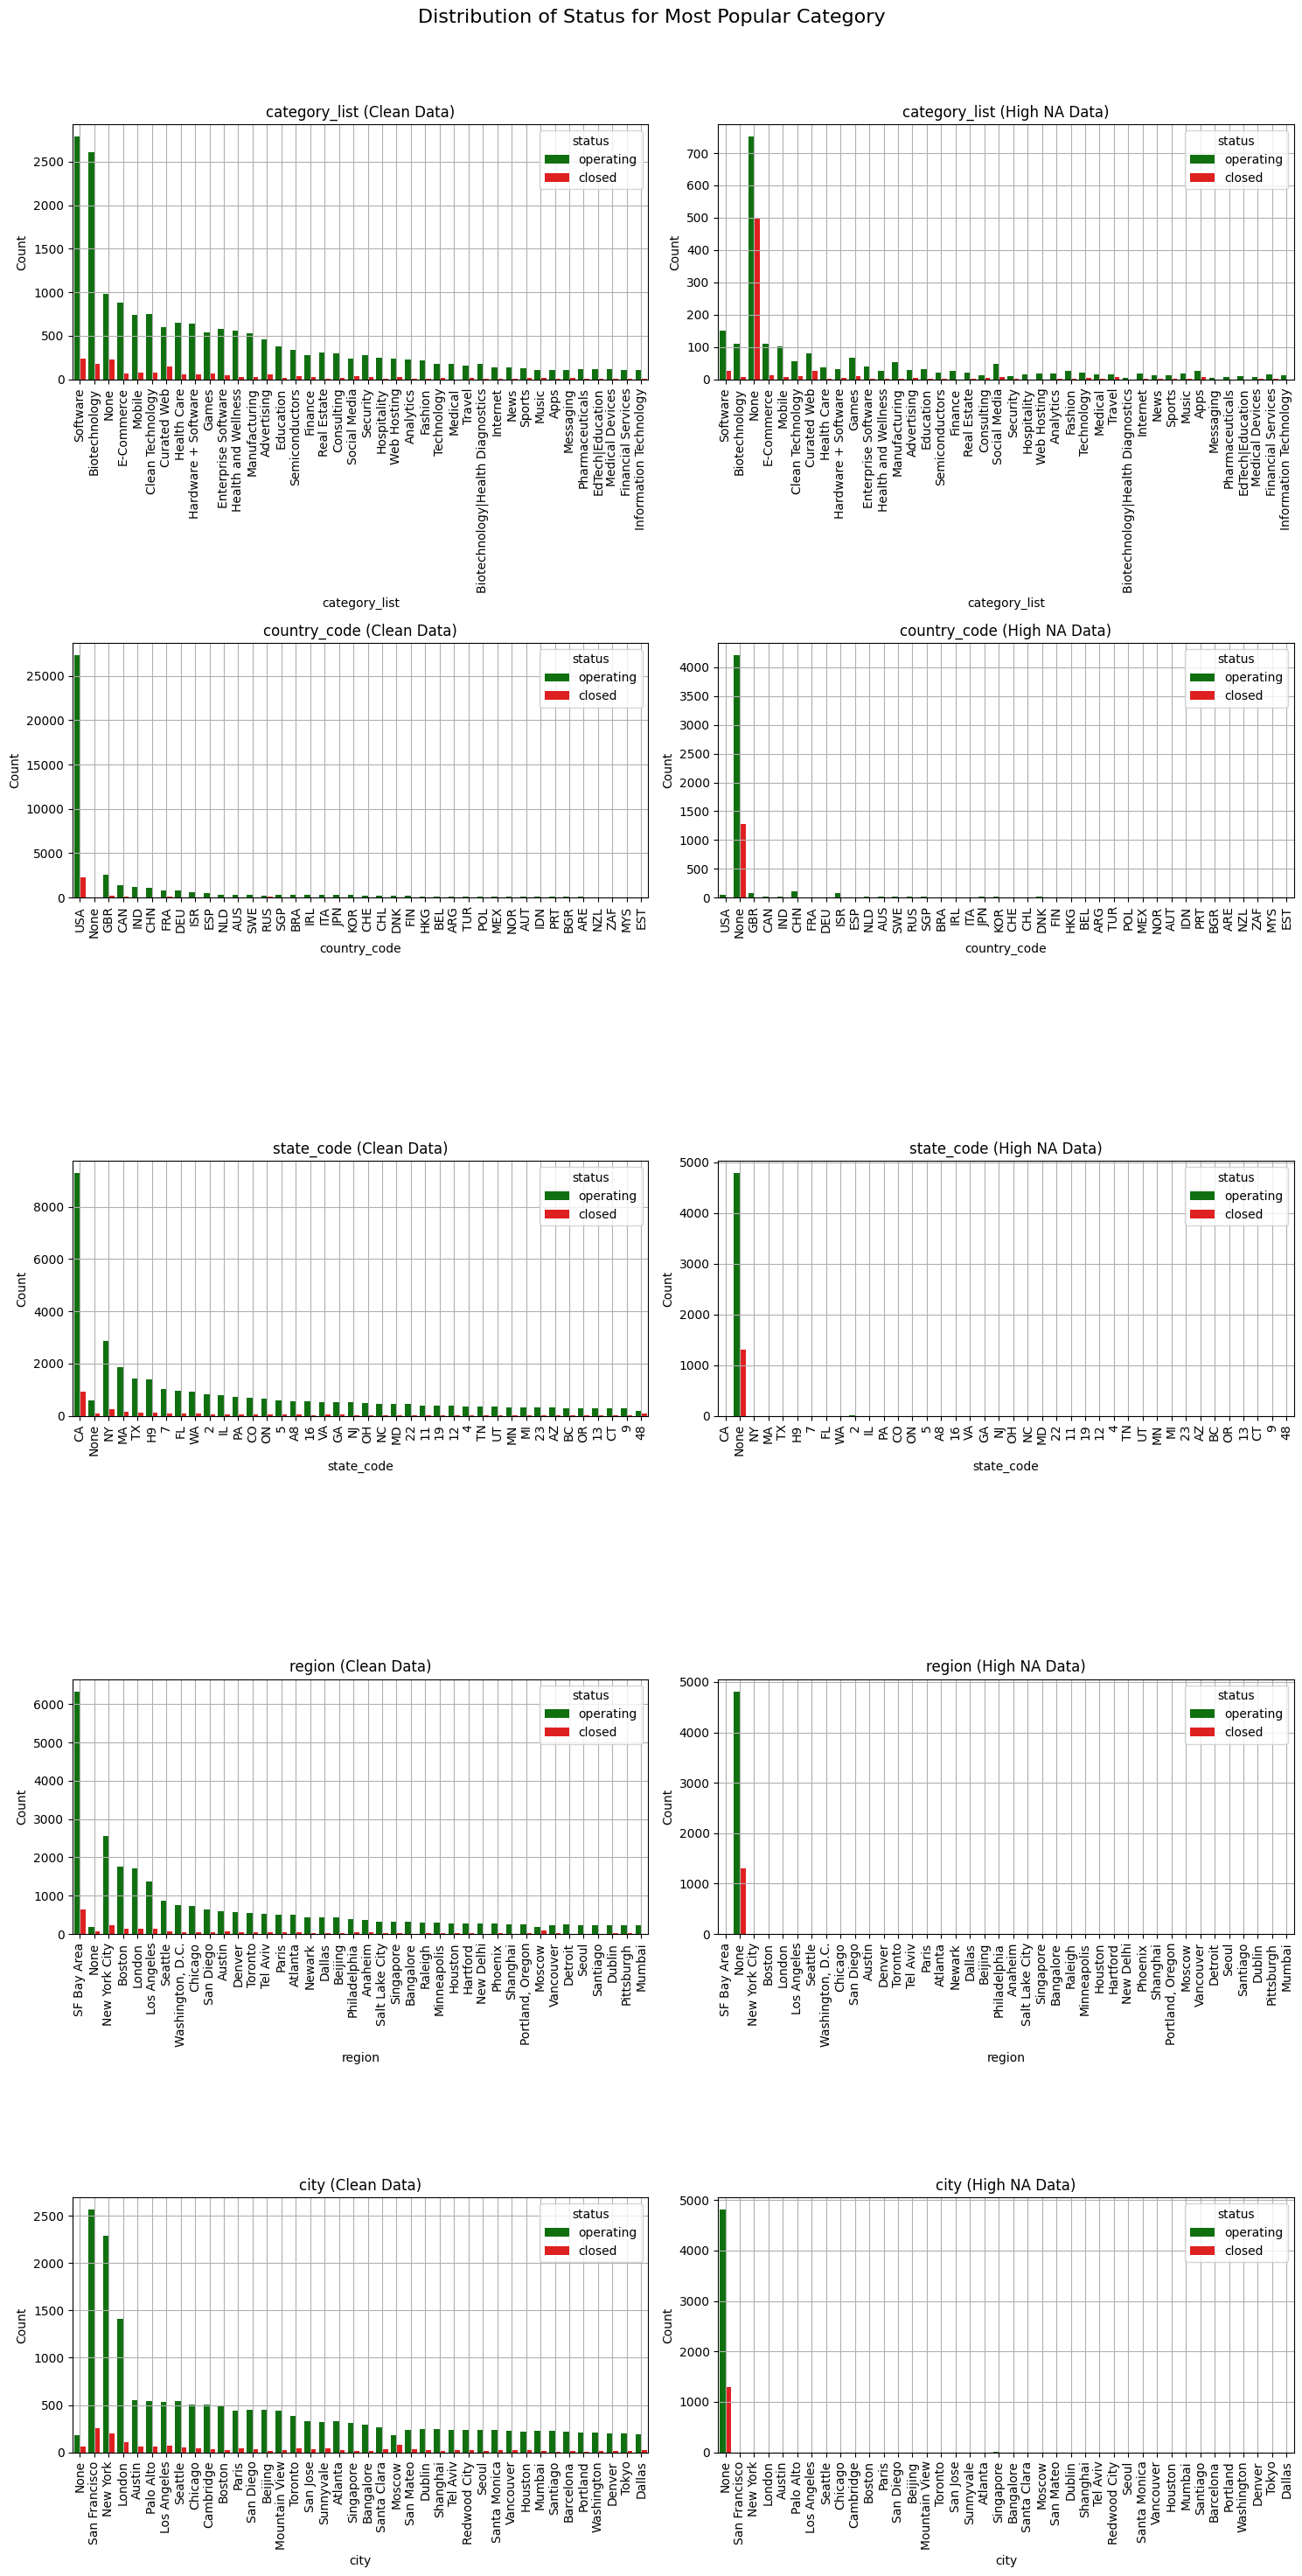

In [26]:
fig, axes = plt.subplots(nrows=len(high_car_columns), ncols=2, figsize=(15, 6*len(high_car_columns)))
fig.suptitle('Distribution of Status for Most Popular Category', fontsize=16)

for i, col in enumerate(high_car_columns):
    top_categories = data[col].value_counts().nlargest(40).index.tolist()
    filtered_data = data[data[col].isin(top_categories)]


    sns.countplot(data=filtered_data[filtered_data['high_na'] == 0], order=top_categories, x=col, hue='status', palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} (Clean Data)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].grid(True)
    axes[i, 0].tick_params(axis='x', rotation=90)

    sns.countplot(data=filtered_data[filtered_data['high_na'] == 1], order=top_categories, x=col, hue='status', palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} (High NA Data)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].grid(True)
    axes[i, 1].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Feature generation

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
 13  high_na            52516 non-null  int32         
dtypes: dat

In [28]:
data = feature_gen(data)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      52516 non-null  object 
 1   category_list             52516 non-null  object 
 2   funding_total_usd         52516 non-null  float64
 3   status                    52516 non-null  object 
 4   country_code              52516 non-null  object 
 5   state_code                52516 non-null  object 
 6   region                    52516 non-null  object 
 7   city                      52516 non-null  object 
 8   funding_rounds            52516 non-null  int64  
 9   high_na                   52516 non-null  int32  
 10  lifetime                  52516 non-null  float64
 11  days_to_first_funding     52516 non-null  int64  
 12  days_to_last_funding      52516 non-null  int64  
 13  days_between_first_last   52516 non-null  int64  
 14  avg_da

## High cardinality values transformation
Значения данных с высокой кардинальностью требуют обработки, для списка категорий применяем word2vec векторизацию [ссылка на функции](#functions-and-classes), для остальных targetencoding

In [30]:
target_encoder = TargetEncoder()

target_encoder.fit(data[['country_code', 'state_code', 'region', 'city', 'category_list']], data['status'])

data[['country_encoded', 'state_code_encoded', 'region_encoded', 'city_encoded', 'category_list_encoded']] = target_encoder.transform(data[['country_code', 'state_code', 'region', 'city', 'category_list']])
data = data.drop(columns=['country_code', 'state_code', 'region', 'city', 'name'])

data[['country_encoded', 'state_code_encoded', 'region_encoded', 'city_encoded']]

country_encoded  state_code_encoded  region_encoded  city_encoded
0             0.912193            0.936841        0.933847      0.933948
1             0.923102            0.908406        0.908465      0.914035
2             0.923102            0.908406        0.908465      0.913630
3             0.766321            0.793911        0.785067      0.785067
4             0.923102            0.929401        0.964728      0.934346
...                ...                 ...             ...           ...
52511         0.916877            0.923697        0.917073      0.960629
52512         0.958445            0.924409        0.955523      0.955523
52513         0.923102            0.908406        0.908465      0.908285
52514         0.923102            0.908406        0.908465      0.913630
52515         0.925839            0.949597        0.958691      0.965120

[52516 rows x 4 columns]

In [31]:
data, vector_columns = handle_high_car(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Columns: 122 entries, funding_total_usd to category_vec_99
dtypes: float32(100), float64(16), int32(1), int64(4), object(1)
memory usage: 28.6+ MB


## New features analysis
Оценим новые признаки, полученные в результате генерации (за исключением векторов категорий)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Columns: 122 entries, funding_total_usd to category_vec_99
dtypes: float32(100), float64(16), int32(1), int64(4), object(1)
memory usage: 28.6+ MB


Всего получили 122 признака

In [33]:
num_columns = ['lifetime', 'days_to_first_funding', 'days_to_last_funding',
               'days_between_first_last', 'avg_days_between_funding', 'avg_funding_per_round',
               'first_funding_epoch', 'last_funding_epoch', 'founded_epoch',
               'lf_ratio', 'funding_total_usd_log', 'name_sentiment',
               'country_encoded', 'state_code_encoded', 'region_encoded',
               'city_encoded']
cat_columns = ['funding_rounds', 'categories_count']

### Numerical

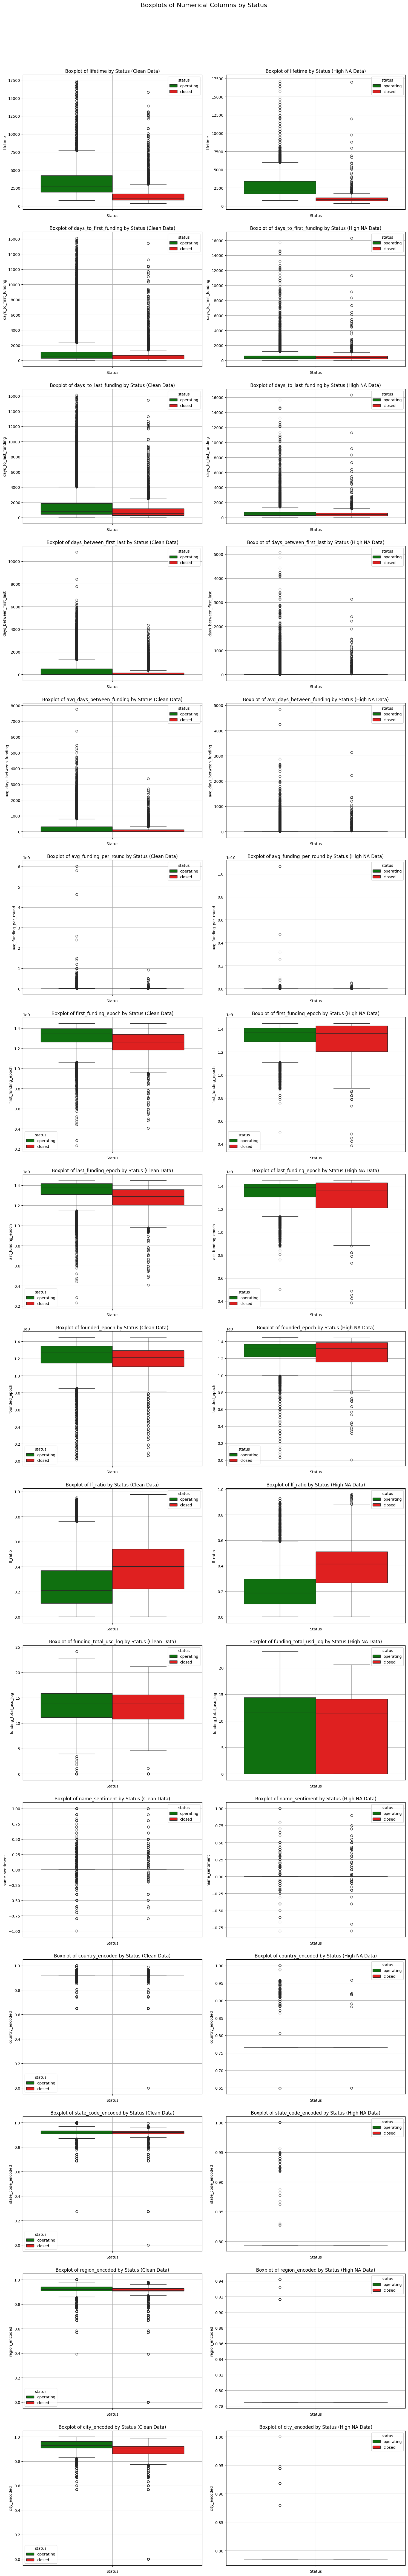

In [34]:
fig, axes = plt.subplots(nrows=len(num_columns), ncols=2, figsize=(15, 6* len(num_columns)))
fig.suptitle('Boxplots of Numerical Columns by Status', fontsize=16)

for i, col in enumerate(num_columns):
    sns.boxplot(data=data[data['high_na'] == 0], hue='status', y=col, palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 0])
    axes[i, 0].set_title(f'Boxplot of {col} by Status (Clean Data)')
    axes[i, 0].set_xlabel('Status')
    axes[i, 0].set_ylabel(col)
    axes[i, 0].grid(True)


    sns.boxplot(data=data[data['high_na'] == 1], hue='status', y=col, palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col} by Status (High NA Data)')
    axes[i, 1].set_xlabel('Status')
    axes[i, 1].set_ylabel(col)
    axes[i, 1].grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Новые числовые признаки показывают, что зависимость целевого признака наиболее выражена для времени жизни стартапа, скорее всего использование признака приведет к ошибкам, так как в тестовых данных может быть представлено большое количество открывшихся недавно стартапов с коротким сроком жизни. По этой же причине мы не можем использовать даты в epoch формате для оценки целевого признака. Распределение остальных признаков пока не дает определить значимых признаков.


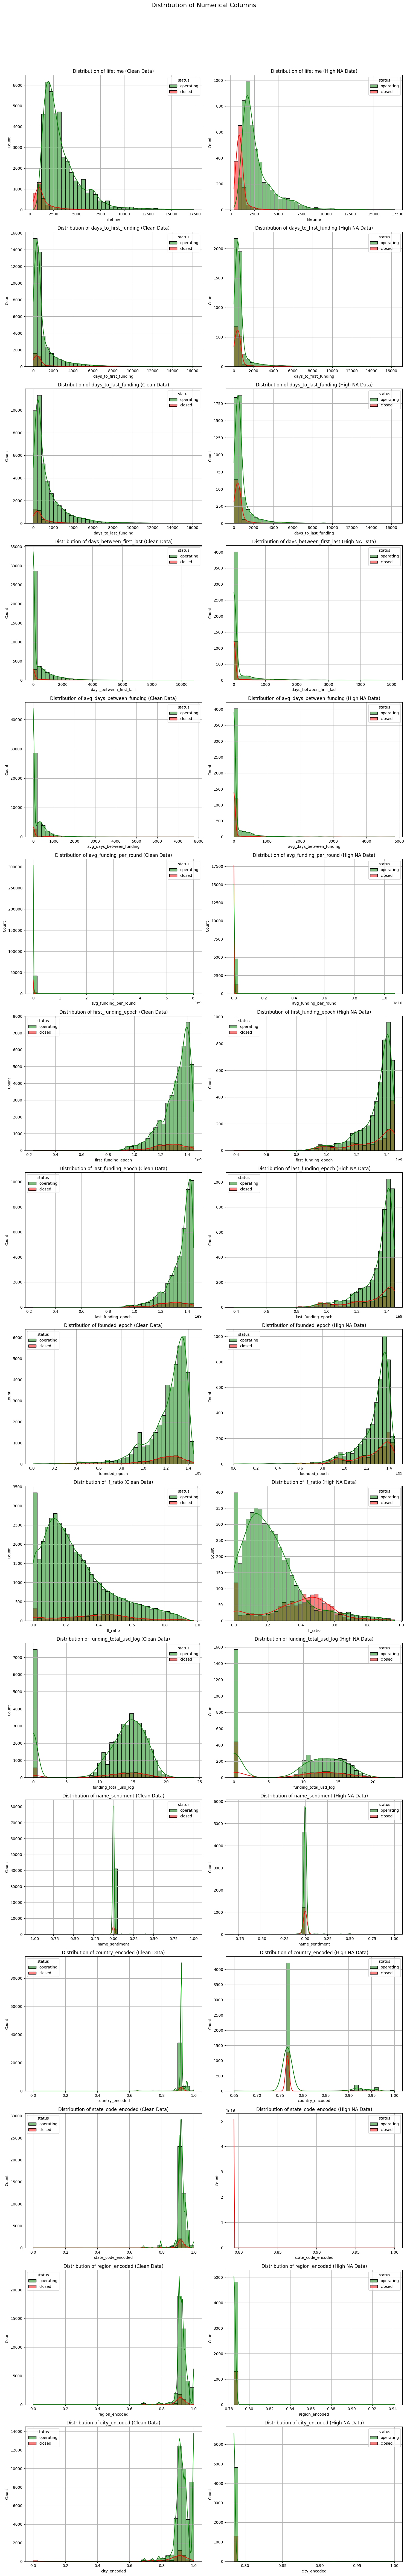

In [35]:
fig, axes = plt.subplots(nrows=len(num_columns), ncols=2, figsize=(15, 6*len(num_columns)))
fig.suptitle('Distribution of Numerical Columns', fontsize=16)

for i, col in enumerate(num_columns):
    sns.histplot(data=data[data['high_na'] == 0], x=col, hue='status', bins=40, ax=axes[i, 0], palette={'operating': 'green', 'closed': 'red'}, kde=True)
    axes[i, 0].set_title(f'Distribution of {col} (Clean Data)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].grid(True)

    sns.histplot(data=data[data['high_na'] == 1], x=col, hue='status', bins=40, ax=axes[i, 1], palette={'operating': 'green', 'closed': 'red'}, kde=True)
    axes[i, 1].set_title(f'Distribution of {col} (High NA Data)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

для значения lifetime < 1250 ярко выражен всплеск положительных значений искомого признака, попробуем добавить дополнительный признак 'low_lt'
для отношения lf_ratio > 0,4 имеем заметное изменение соотношения status, провермим дополнительный признак 'high_lf_ratio'
отдельно добавим признаки имели ли стартапы менее 4 раундов финасирования 'had_low_rounds'
и низкий объем финансирования 'low_funding' для признака funding_total_usd_log меньше 5 

In [36]:
data['high_lf_ratio'] = (data['lf_ratio'] > 0.4).astype(int)
data['had_low_rounds'] = (data['funding_rounds'] < 4).astype(int)
data['low_funding'] = (data['funding_total_usd_log'] < 5).astype(int)
data['low_lt'] = (data['lifetime'] < 1250).astype(int)

In [37]:
cat_columns.extend(['high_lf_ratio', 'had_low_rounds', 'low_funding', 'low_lt'])

### Categorial

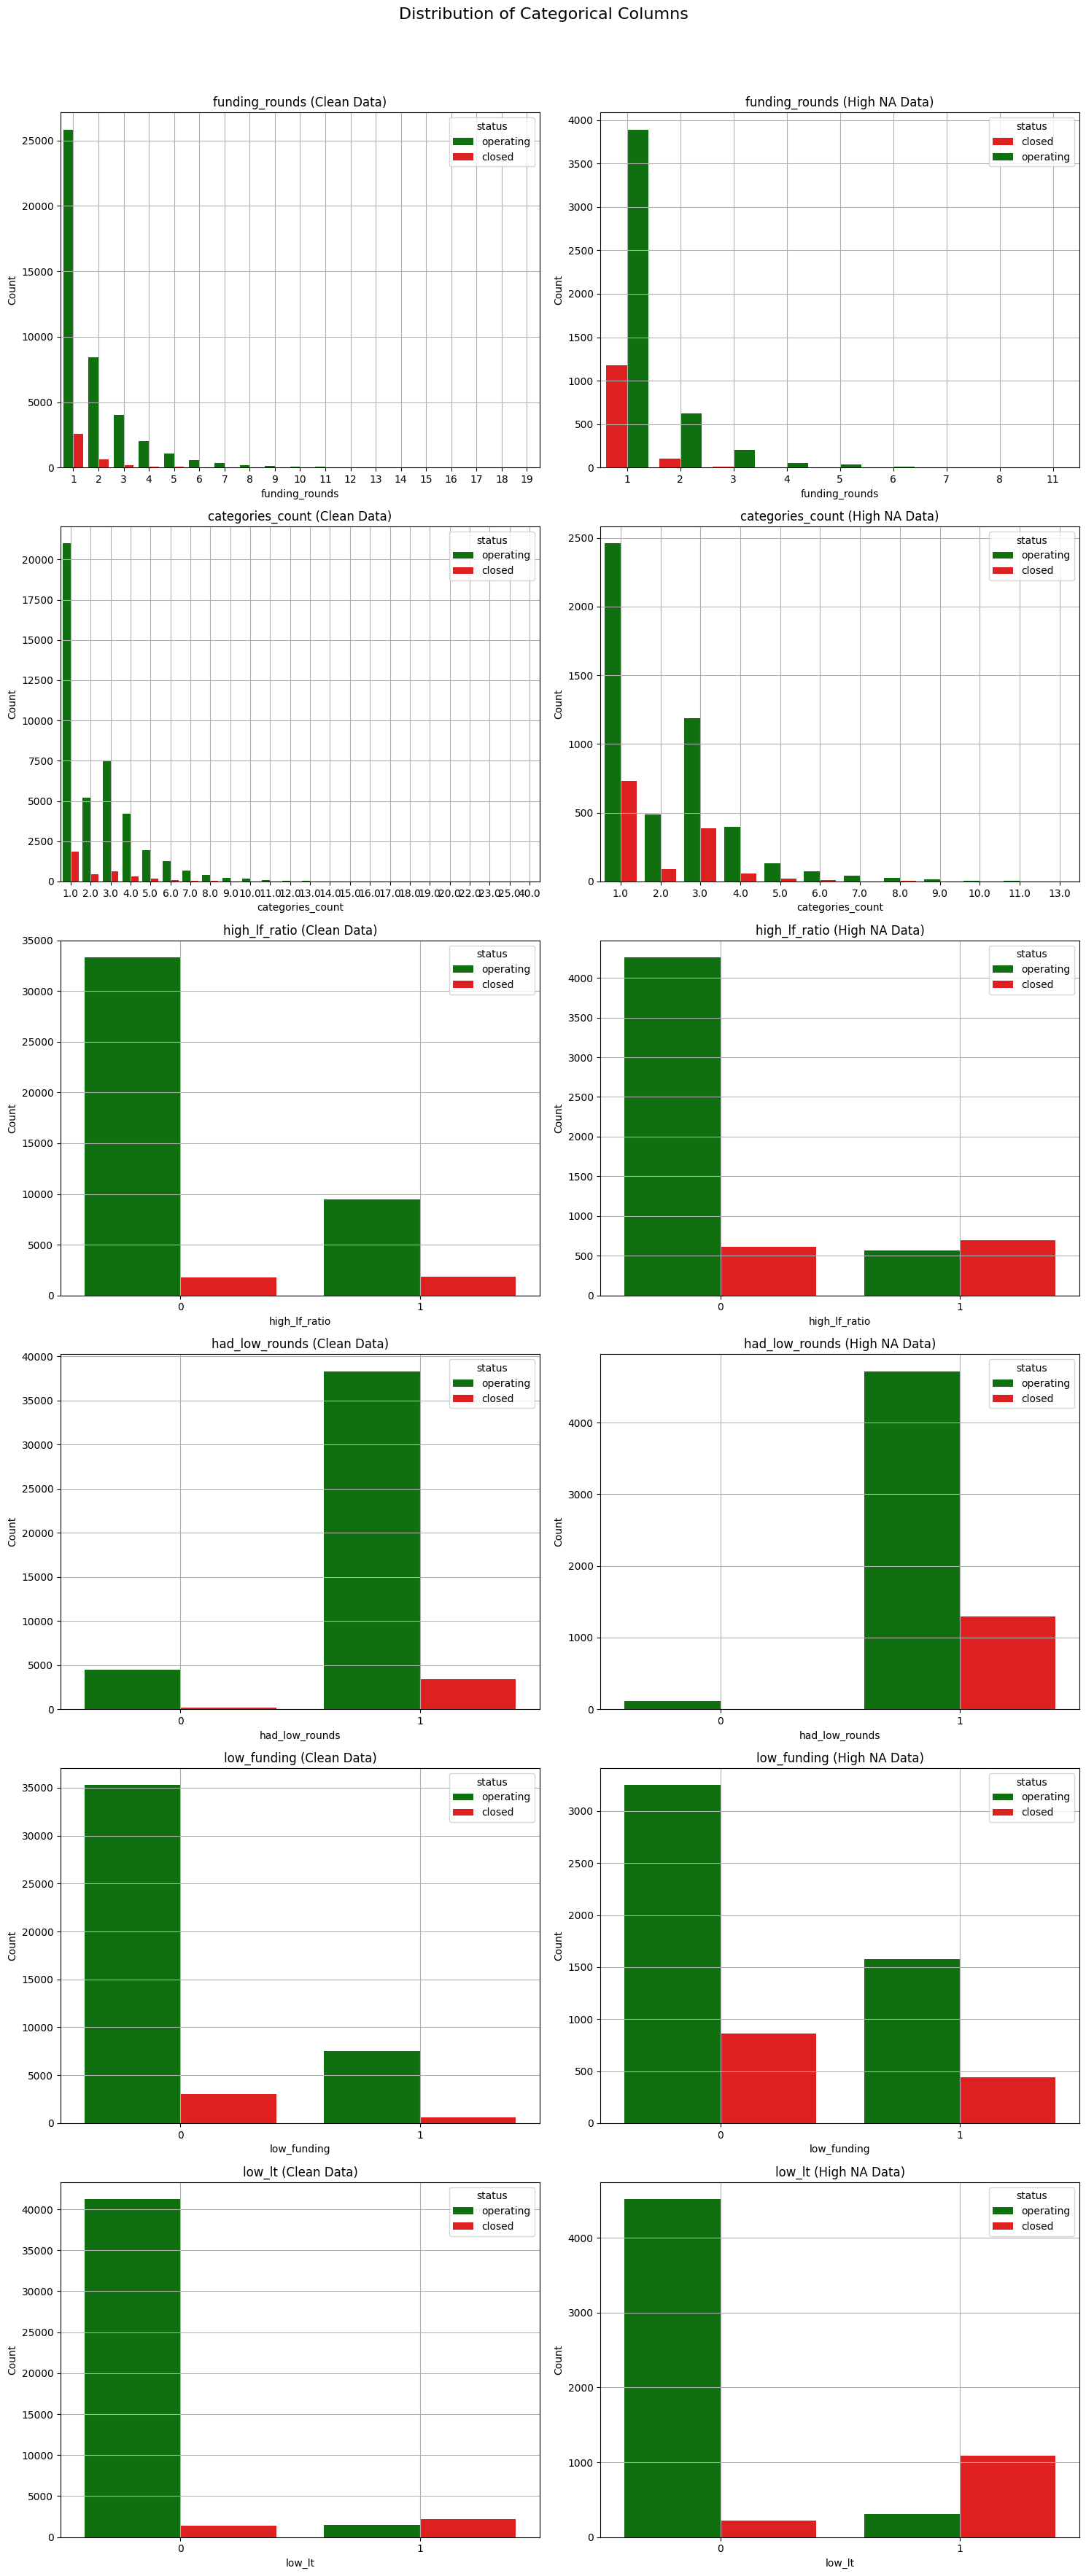

In [38]:
fig, axes = plt.subplots(nrows=len(cat_columns), ncols=2, figsize=(15, 6*len(cat_columns)))
fig.suptitle('Distribution of Categorical Columns', fontsize=16)

for i, col in enumerate(cat_columns):
    sns.countplot(data=data[data['high_na'] == 0], x=col, hue='status', palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} (Clean Data)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].grid(True)

    sns.countplot(data=data[data['high_na'] == 1], x=col, hue='status', palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} (High NA Data)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Значение lifetime оказывает наибольшее влияние на целевую переменную.  А объем привлеченных инвестиций пока не значительно на нее влияет.

## Сorrelation

Оценим phik полученных признаков

In [39]:
data['status'] = data['status'].map({'operating': 0, 'closed': 1}) # приводим целевой признак к числовому виду

In [40]:
phik_matrix = data.drop(columns=vector_columns).phik_matrix() # создаем phik матрицу без векторов категорий

interval columns not set, guessing: ['funding_total_usd', 'status', 'funding_rounds', 'high_na', 'lifetime', 'days_to_first_funding', 'days_to_last_funding', 'days_between_first_last', 'avg_days_between_funding', 'avg_funding_per_round', 'first_funding_epoch', 'last_funding_epoch', 'founded_epoch', 'categories_count', 'lf_ratio', 'funding_total_usd_log', 'name_sentiment', 'country_encoded', 'state_code_encoded', 'region_encoded', 'city_encoded', 'category_list_encoded', 'high_lf_ratio', 'had_low_rounds', 'low_funding', 'low_lt']


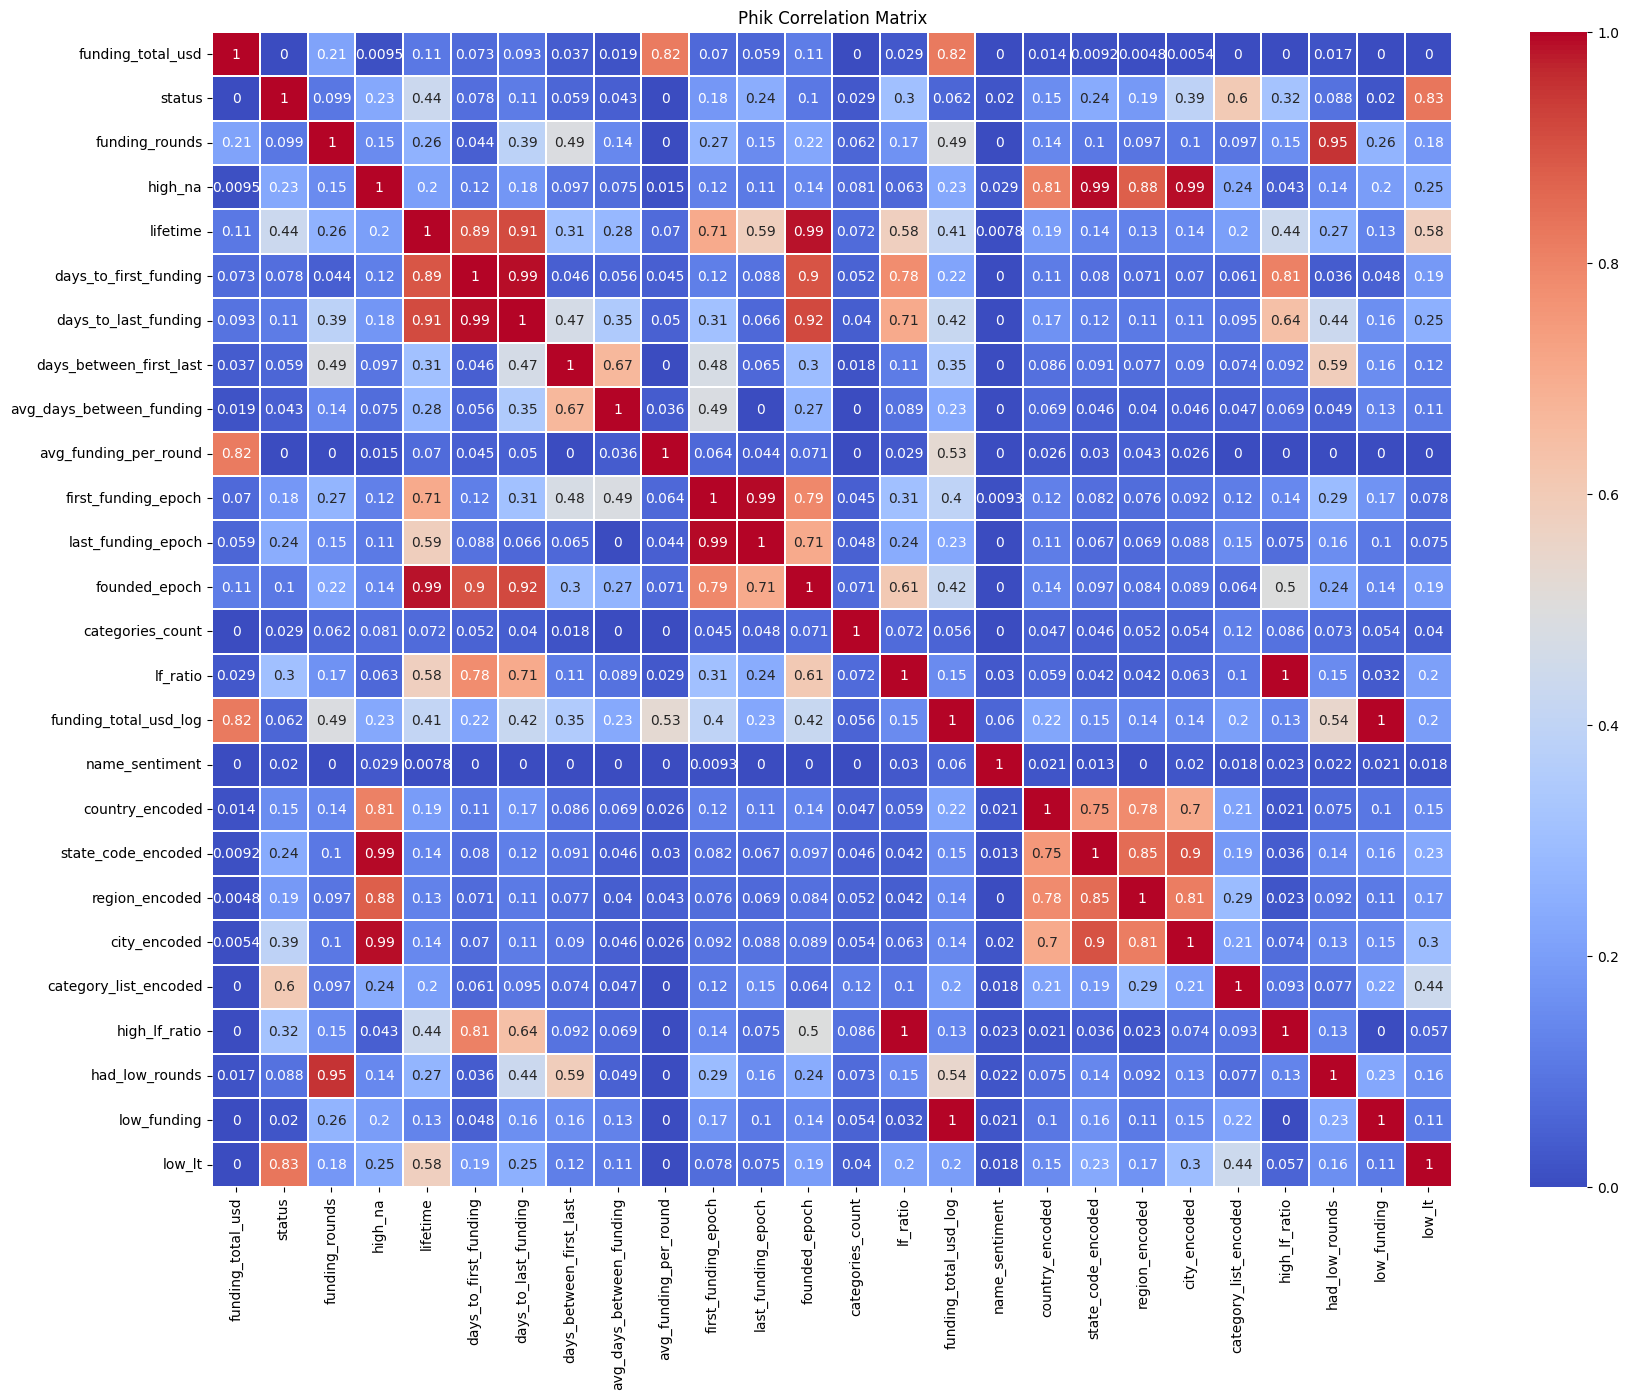

In [41]:
plt.figure(figsize=(20, 15))
sns.heatmap(phik_matrix, cmap='coolwarm', annot=True, linewidths=0.1)
plt.title('Phik Correlation Matrix')
plt.show()

Получаем несколько признаков с выраженной мультиколлинеарностью, в качестве порога установим значение в 0.8. Как и показал статистических анализ, lifetime оказывает значительное влияние на status, что примечательно, целевое кодирование признака списка категорий также показало значительное влияние на значение status

## Feature selection

In [42]:
threshold = 0.8

# Создаем маску для значений PhiK > 0.8 по модулю
high_phik_mask = (phik_matrix.abs() > threshold) & (phik_matrix != 1.0)
high_phik_features = phik_matrix[high_phik_mask].stack().reset_index()
high_phik_features.columns = ['Feature 1', 'Feature 2', 'PhiK']
high_phik_features['Feature 1'], high_phik_features['Feature 2'] = zip(
    *high_phik_features.apply(lambda row: sorted([row['Feature 1'], row['Feature 2']]), axis=1)
)
high_phik_features = high_phik_features.drop_duplicates()
print(high_phik_features)


                Feature 1              Feature 2      PhiK
0   avg_funding_per_round      funding_total_usd  0.819290
1       funding_total_usd  funding_total_usd_log  0.822538
2                  low_lt                 status  0.829004
3          funding_rounds         had_low_rounds  0.951906
4         country_encoded                high_na  0.806723
5                 high_na     state_code_encoded  0.994183
6                 high_na         region_encoded  0.877019
7            city_encoded                high_na  0.990936
8   days_to_first_funding               lifetime  0.894247
9    days_to_last_funding               lifetime  0.910526
10          founded_epoch               lifetime  0.986658
12  days_to_first_funding   days_to_last_funding  0.989795
13  days_to_first_funding          founded_epoch  0.896446
14  days_to_first_funding          high_lf_ratio  0.808061
17   days_to_last_funding          founded_epoch  0.915490
19    first_funding_epoch     last_funding_epoch  0.9947

Отберем подходящие признаки для обучения моделей

In [226]:
# критерии для отбрасывания
features_to_drop = [
    # 'lifetime', # скорее всего переобучит данные, так как мы не знаем, что будет в тестовых
    'low_lt', # скорее всего переобучит данные, так как мы не знаем, что будет в тестовых
    'high_lf_ratio', # представлен как категориальный
    'lf_ratio',
    'days_to_last_funding', # не имеет смысла, так как чаще всего равен количеству дней до первого финансирования
    # 'funding_rounds',  # представлен как категориальный
    'founded_epoch', # прямо указывает на lifetime стартапа 
    'first_funding_epoch', # ввиду больших значений, и частоте в 1 раунд, будет копировать 'last_funding_epoch'
    # 'last_funding_epoch', 
    'avg_funding_per_round', # не оказывает влияния на целевой признак, практически копирует funding_total_usd
    'funding_total_usd',  # без обработки имеет большое число выбросов, поэтому оставляем нормализованное значение
    # 'city_encoded', # сильно корррелирует с city и region, не имеет значения для high_na данных
    'state_code_encoded',  # сильно корррелирует с city и region, не имеет значения для high_na данных
    'category_list_encoded', # векторизован
    'region_encoded', # сильно корррелирует с city и region, не имеет значения для high_na данных
    'days_to_first_funding',
    # 'name_sentiment',

    'high_na',
    # 'country_encoded',
    'had_low_rounds',
    ]
first_set = data.drop(columns=features_to_drop)
first_set = first_set.drop(columns=vector_columns)
first_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   status                    52516 non-null  int64  
 1   funding_rounds            52516 non-null  int64  
 2   lifetime                  52516 non-null  float64
 3   days_between_first_last   52516 non-null  int64  
 4   avg_days_between_funding  52516 non-null  float64
 5   last_funding_epoch        52516 non-null  float64
 6   categories_count          52516 non-null  float64
 7   funding_total_usd_log     52516 non-null  float64
 8   name_sentiment            52516 non-null  float64
 9   country_encoded           52516 non-null  float64
 10  city_encoded              52516 non-null  float64
 11  low_funding               52516 non-null  int32  
dtypes: float64(8), int32(1), int64(3)
memory usage: 4.6 MB


In [227]:
high_phik_features[~high_phik_features['Feature 1'].isin(features_to_drop) & ~high_phik_features['Feature 2'].isin(features_to_drop)]

Empty DataFrame
Columns: [Feature 1, Feature 2, PhiK]
Index: []

## Cross-validation pipelines

In [228]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

data_l = [
    first_set,
    ]

def objective(trial, X, y):
    classifier_name = trial.suggest_categorical('classifier', [
        # 'DecisionTree',
        # 'RandomForest',
        'XGBoost',
        # 'CatBoost',
        ])
    
    if classifier_name == 'DecisionTree':
        max_depth = trial.suggest_int('max_depth', 2, 32)
        classifier_obj = DecisionTreeClassifier(max_depth=max_depth, class_weight='balanced')
        
    elif classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 10, 500)
        max_depth = trial.suggest_int('max_depth', 10, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
        max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 32)
        classifier_obj = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes,
                                                 max_features='log2', min_samples_leaf=min_samples_leaf, class_weight='balanced')
        
    elif classifier_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 5, 10)
        max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 32)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        classifier_obj = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes,
                                        learning_rate=learning_rate, use_label_encoder=False, eval_metric='auc')
        
    else:
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 2, 16)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        classifier_obj = CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, verbose=0)
    
    smote = SMOTE(random_state=RANDOM_STATE)
    X, y = smote.fit_resample(X, y)


    pipeline = Pipeline([
        # ('scaler', StandardScaler()),
        ('classifier', classifier_obj),
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(pipeline, X, y, n_jobs=-1, cv=cv, scoring='f1_weighted')
    accuracy = score.mean()
    return accuracy


studies = []
for df in data_l:
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, df.drop(columns='status'), df['status']), n_trials=100)

    print('Best trial:')
    trial = study.best_trial
    print(f'  Value: {trial.value}')
    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
    print('\n\n\n')
    studies.append(study)

[I 2025-02-07 17:11:01,030] A new study created in memory with name: no-name-866d1b92-6ae0-4c52-bb78-0741f20a0045
[I 2025-02-07 17:11:02,932] Trial 0 finished with value: 0.988812349883163 and parameters: {'classifier': 'XGBoost', 'n_estimators': 197, 'max_depth': 9, 'max_leaf_nodes': 20, 'learning_rate': 0.18451006742909026}. Best is trial 0 with value: 0.988812349883163.
[I 2025-02-07 17:11:04,217] Trial 1 finished with value: 0.9855973547916437 and parameters: {'classifier': 'XGBoost', 'n_estimators': 106, 'max_depth': 9, 'max_leaf_nodes': 27, 'learning_rate': 0.10711249534039734}. Best is trial 0 with value: 0.988812349883163.
[I 2025-02-07 17:11:04,891] Trial 2 finished with value: 0.9830648684538505 and parameters: {'classifier': 'XGBoost', 'n_estimators': 52, 'max_depth': 8, 'max_leaf_nodes': 15, 'learning_rate': 0.16455091552911502}. Best is trial 0 with value: 0.988812349883163.
[I 2025-02-07 17:11:05,676] Trial 3 finished with value: 0.9850404989295093 and parameters: {'class

Best trial:
  Value: 0.9892326095760098
  Params: 
    classifier: XGBoost
    n_estimators: 182
    max_depth: 10
    max_leaf_nodes: 2
    learning_rate: 0.2999060468946113






c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:13:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


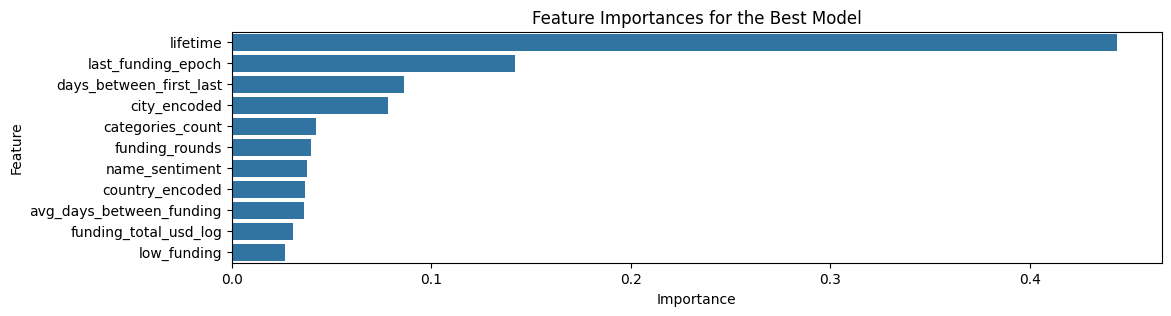

In [229]:
# Extract the best model from the study
best_params = studies[0].best_trial.params
best_model = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    use_label_encoder=False,
    eval_metric='logloss'
)
# best_model = RandomForestClassifier(
#     n_estimators = best_params['n_estimators'],
#     max_depth = best_params['max_depth'],
#     min_samples_leaf = best_params['min_samples_leaf'],
#     max_leaf_nodes = best_params['max_leaf_nodes'],
# )

# Fit the model on the entire dataset
best_model.fit(first_set.drop(columns=['status']), first_set['status'])

# Get feature importances
importances = best_model.feature_importances_
features = first_set.drop(columns=['status']).columns

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances[feature_importances['Importance'] > 0]
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, len(feature_importances)//3))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances for the Best Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Test data prediction

In [230]:
test['high_na'] = (test.isna().sum(axis=1) > 3).astype(int)
test.info()
test_f = test.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
 11  high_na            13125 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(2), object(6)
memory usage: 1.2+ MB


In [231]:
# Преобразование тестовых данных
test_f = feature_gen(test_f)
txt_columns = test_f.select_dtypes(include='object').columns
num_columns = test_f.select_dtypes(include=['int64', 'float64', 'int32']).columns

# # Заполнение пропущенных значений
test_f[txt_columns] = test_f.loc[:, txt_columns].fillna('None', axis=1)
test_f[num_columns] = test_f.loc[:, num_columns].fillna(0, axis=1)

In [232]:
test_f, _ = handle_high_car(test_f)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Columns: 121 entries, name to category_vec_99
dtypes: float32(100), float64(16), object(5)
memory usage: 7.1+ MB


In [233]:
test_f[['country_encoded', 'state_code_encoded', 'region_encoded', 'city_encoded', 'category_list_encoded']] = target_encoder.transform(test[['country_code', 'state_code', 'region', 'city', 'category_list']])
test_f['high_lf_ratio'] = (test_f['lf_ratio'] > 0.4).astype(int)
test_f['low_lt'] = (test_f['lifetime'] < 1200).astype(int)
test_f['had_low_rounds'] = (test_f['funding_rounds'] < 4).astype(int)
test_f['low_funding'] = (test_f['funding_total_usd_log'] < 5).astype(int)

In [234]:
test_f = test_f[first_set.columns.drop('status')]
# second_set_t = test_f[test_f['high_na'] == 0][second_set.columns.drop('status')]


test_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   funding_rounds            13125 non-null  float64
 1   lifetime                  13125 non-null  float64
 2   days_between_first_last   13125 non-null  float64
 3   avg_days_between_funding  13125 non-null  float64
 4   last_funding_epoch        13125 non-null  float64
 5   categories_count          13125 non-null  float64
 6   funding_total_usd_log     13125 non-null  float64
 7   name_sentiment            13125 non-null  float64
 8   country_encoded           13125 non-null  float64
 9   city_encoded              13125 non-null  float64
 10  low_funding               13125 non-null  int32  
dtypes: float64(10), int32(1)
memory usage: 1.1 MB


In [235]:
test_predictions = best_model.predict(test_f)

# # Вывод первых 10 предсказаний
print(test_predictions[:20])
print(f'Количество стартапов, которые закроются:  {test_predictions.sum()}')

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Количество стартапов, которые закроются:  1153


In [236]:
# Create a DataFrame with the names and predictions
predictions_df = pd.DataFrame({
    'name': test['name'],
    'status': np.where(test_predictions == 0, 'operating', 'closed')
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

# Display the first few rows of the DataFrame to verify
print(predictions_df.head())

                     name     status
0              Crystalsol  operating
1        JBI Fish & Wings  operating
2                COINPLUS  operating
3  Imagine Communications  operating
4                   DNA13  operating
